<a href="https://colab.research.google.com/github/JuliusYU-Macau/JuliusYU-Macau.github.io/blob/main/Diabetes_Prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Model Name: Early Diabetes Risk Prediction for Elder  

## Description of Data (Original Data)
* Data update version: 2018-02-15
* Time Period: 1996-2008 (12 years)
* Subject Terms: aging, cardiovascular disease, chronic illnesses, developing nations, diabetes, early life conditions, health status, obesity, older adults, physical limitations, smoking, socioeconomic status, tobacco products, tobacco use
* 180 attributes
* Size of data: 88, 273
* Geographic Coverage: Argentina, Puerto Rico, United States, Uruguay, China (Peoples Republic), England, Ghana, India, Russia, Costa Rica, Cuba, Netherlands, Bangladesh, Barbados, Taiwan, Brazil, South Africa, Mexico, Chile, Indonesia
* #Note: The description of data can be seen in Codebook.pdf

## Real Data (In experiment)
* 5 Modules (Demographics, system, early life conditions, adult lifestyle, adult health outcome) and 1 output (diabetes: 1 or 0)
* 36 attributes
* Sample size: 23845 (for categorical attributes, no missing value. others has missing value) i.e., GOODHEALTH, WAIST, HIP 
* still 12 years

## Innovation of Data (Compare to the previous research works)
* Consider the social background (income, married? etc)
* Time period is long, previous works only consider one year or not consider the time
* Consider children health conditions, adults healthcare conditions (other works not consider, but it is important for chronic diseases)

## Innovation of Model

## Reference (Paper only)
* APA format

### ----------------------------------- Python Packages -----------------------------------

In [1]:
# For Google Colab
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
# Import All Packages at here
import numpy as np
import pandas as pd
from time import time
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler
from operator import itemgetter
import torch
from torch import nn
import torch.nn as nn
from sklearn.model_selection import train_test_split
# from torchvision.transforms import ToTensor

# from torch.utils.data import DataLoader

# from torch.autograd import Variable

# import torch.nn.functional as F

# Pretty display for notebooks
%matplotlib inline

In [3]:
from torch.utils.data import DataLoader

In [4]:
import torch.nn.functional as F

In [5]:
from sklearn.preprocessing import OneHotEncoder

In [6]:
from torch.utils.data import Dataset, DataLoader

In [7]:
import torch.optim as optim

In [8]:
import warnings
warnings.filterwarnings("ignore")

import os
import gc
import joblib
import pandas as pd
import numpy as np
import tensorflow as tf
from sklearn.model_selection import StratifiedKFold
from sklearn import metrics, preprocessing
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras.models import Model, load_model
from tensorflow.keras import callbacks
from tensorflow.keras import backend as K
from tensorflow.keras import utils

### ----------------------------------- End of Python Packages -----------------------------------

### ----------------------------------- Data Description -----------------------------------

In [ ]:
# # read data and data description (For Local Environment)
# origin_data = pd.read_csv('//Volumes//GoogleDrive//My Drive//Experiment//Data//Data_Categorical Attributes.csv')
# origin_data.describe()
# origin_data.head(100)

In [9]:
# read data and data description (For Colab Environment)
origin_data = pd.read_csv('//content//drive//My Drive//Experiment//Data//Data_Categorical Attributes - Oversampling.csv')
origin_data.describe()
origin_data.head(100)

,GENDER,AGEGROUPVER2,CIVIL,EDUCATION,QUINT,WEALTH_INDEX,HSCORE,REGIME,RURALFIN,SMOKE,EXERCISE,DRINK,HEALTHUSE,POORHEALTH,GOODHEALTH,NADLGT0,NADLGT0_ALT,NIADLGT0,NADLGT0HARM,BATH,DRESS,TOILET,TRANSFER,BOW,HYPERTENSION,RESPIRATORY,HEART,STROKE,ARTHRITIS,NCHRONIC,WEIGHT,WAIST,HIP,BMI_CAT,OBESITY,DIABETES
0,1,6,1,2,4,2,61,4,1,0,0,0,1,0,2,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,4,4,4,5,1,0
1,1,5,1,2,5,3,144,5,1,0,0,0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,0,0
2,1,5,1,1,2,1,144,5,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0,0
3,1,6,3,2,1,2,39,2,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,1,3,2,2,3,4,0,0
4,0,3,1,2,3,3,144,5,1,1,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,3,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0,3,4,3,3,3,130,4,1,1,1,1,0,0,2,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,3,4,0,0
96,0,4,4,3,5,3,175,3,0,0,0,0,0,0,3,0,1,0,0,0,0,0,0,1,0,0,0,0,0,0,4,2,3,3,0,0
97,1,5,4,3,3,3,65,2,0,0,0,0,1,0,2,0,1,0,0,0,0,0,0,0,1,0,1,0,1,2,4,3,4,5,1,0
98,1,6,4,2,2,2,33,3,1,0,0,0,1,0,2,0,1,0,0,0,0,0,0,1,1,1,0,0,0,2,3,4,4,5,1,1


In [10]:
origin_data.describe()

,GENDER,AGEGROUPVER2,CIVIL,EDUCATION,QUINT,WEALTH_INDEX,HSCORE,REGIME,RURALFIN,SMOKE,EXERCISE,DRINK,HEALTHUSE,POORHEALTH,GOODHEALTH,NADLGT0,NADLGT0_ALT,NIADLGT0,NADLGT0HARM,BATH,DRESS,TOILET,TRANSFER,BOW,HYPERTENSION,RESPIRATORY,HEART,STROKE,ARTHRITIS,NCHRONIC,WEIGHT,WAIST,HIP,BMI_CAT,OBESITY,DIABETES
count,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.00000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000,41702.000000
mean,0.588653,4.898806,2.036641,2.211357,3.066639,2.277541,107.111074,4.111410,0.513908,0.370078,0.241787,0.324181,0.758261,0.37684,1.959283,0.182126,0.653182,0.305717,0.158649,0.058151,0.071915,0.051269,0.101362,0.348736,0.445782,0.084217,0.206177,0.052539,0.307347,1.358112,2.735073,2.732723,2.693300,3.636252,0.206489,0.489377
std,0.492084,1.849217,1.428907,0.896894,1.418546,0.733200,43.254443,1.007304,0.499813,0.482831,0.428171,0.468074,0.428142,0.48460,0.735505,0.385953,0.475963,0.460716,0.365353,0.234031,0.258350,0.220548,0.301811,0.476576,0.497058,0.277716,0.404564,0.223115,0.461400,1.143794,1.064198,1.091912,1.096606,0.941202,0.404790,0.499893
min,0.000000,2.000000,1.000000,1.000000,1.000000,1.000000,33.000000,2.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,1.000000,1.000000,0.000000,0.000000
25%,0.000000,4.000000,1.000000,2.000000,2.000000,2.000000,61.000000,4.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.00000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,2.000000,2.000000,2.000000,3.000000,0.000000,0.000000
50%,1.000000,5.000000,1.000000,2.000000,3.000000,2.000000,125.000000,4.000000,1.000000,0.000000,0.000000,0.000000,1.000000,0.00000,2.000000,0.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,3.000000,3.000000,3.000000,4.000000,0.000000,0.000000
75%,1.000000,6.000000,4.000000,3.000000,4.000000,3.000000,144.000000,5.000000,1.000000,1.000000,0.000000,1.000000,1.000000,1.00000,3.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.000000,0.000000,0.000000,1.000000,2.000000,4.000000,4.000000,4.000000,4.000000,0.000000,1.000000
max,1.000000,9.000000,5.000000,4.000000,5.000000,3.000000,175.000000,5.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.00000,3.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,1.000000,6.000000,4.000000,4.000000,4.000000,5.000000,1.000000,1.000000


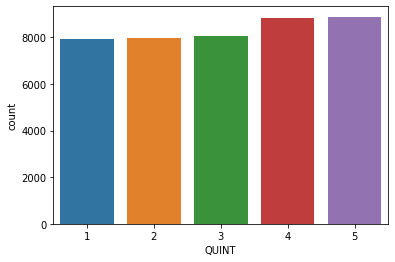

In [11]:
sns.countplot(x = 'QUINT', data=origin_data)

### ----------------------------------- End of Data Description -----------------------------------

### ----------------------------------- Diabetes-based CF -----------------------------------

In [ ]:
item_df = pd.DataFrame(origin_data)

### DBCF_data represent the columns which used for CF
### 只有GOODHEALTH，WAIST和HIP有缺失值，其中WAIST和HIP的表示形式是NULL，GOODHEALTH是0.0

In [ ]:
DBCF_data = item_df[['HSCORE','GOODHEALTH','WEIGHT','WAIST','HIP','BMI']]

In [ ]:
current.head(1000)

,HSCORE,GOODHEALTH,WEIGHT,WAIST,HIP,BMI
0,61,66.6667,93.0,131.0000,129.0000,43.62920
1,144,66.6667,65.5,88.0000,100.0000,24.65279
2,144,50.0000,32.0,64.2000,84.4000,17.25027
3,39,83.3333,53.0,87.0000,97.0000,25.20809
4,144,100.0000,69.0,76.5000,90.5000,23.65230
...,...,...,...,...,...,...
995,135,66.6667,51.0,84.0000,99.0000,22.22005
996,33,100.0000,55.0,83.0000,96.0000,24.60823
997,46,100.0000,74.0,94.0000,105.0000,24.44180
998,61,66.6667,81.4,111.4000,101.8000,32.36071


In [ ]:
current.loc[321]

HSCORE              33
GOODHEALTH     33.3333
WEIGHT            74.5
WAIST              0.0
HIP           101.0000
BMI           27.03585
Name: 321, dtype: object

In [ ]:
current = DBCF_data.copy()

In [ ]:
current

,HSCORE,GOODHEALTH,WEIGHT,WAIST,HIP,BMI
0,61,66.6667,93.0,131.0000,129.0000,43.62920
1,144,66.6667,65.5,88.0000,100.0000,24.65279
2,144,50.0000,32.0,64.2000,84.4000,17.25027
3,39,83.3333,53.0,87.0000,97.0000,25.20809
4,144,100.0000,69.0,76.5000,90.5000,23.65230
...,...,...,...,...,...,...
23840,125,83.3333,63.0,81.0000,103.0000,25.23634
23841,112,33.3333,40.0,74.0000,77.0000,15.24158
23842,125,33.3333,75.0,98.0000,109.0000,30.04326
23843,144,100.0000,46.0,84.5000,89.5000,19.65056


In [ ]:
for i in range(len(current['WAIST'])):
    if current.loc[i]['WAIST'] == '#NULL!':
        current.loc[i,'WAIST'] = 0.0

In [ ]:
for i in range(len(current['HIP'])):
    if current.loc[i]['HIP'] == '#NULL!':
        current.loc[i,'HIP'] = 0.0

In [ ]:
print("h")

h


--------以上代码替换了NULL为0.0--------------------

### ----------------------------------- End of DB-CF -----------------------------------

### 以下代码是不考虑协同过滤的

### ----------------------------------- Data Preprocessing -----------------------------------

必须将HSCORE一起算入，不然划分数据集会出现问题

In [12]:
pre = pd.DataFrame(origin_data)

In [13]:
# current_data = pre.drop(['ID'],axis = 1)
current_data = pre

In [14]:
# 创建输入和输出数据
X = current_data.iloc[:,0:-1]
y = current_data.iloc[:,-1]
print(X)
print("-------------------------")
print(y)

       GENDER  AGEGROUPVER2  CIVIL  EDUCATION  ...  WAIST  HIP  BMI_CAT  OBESITY
0           1             6      1          2  ...      4    4        5        1
1           1             5      1          2  ...      3    3        3        0
2           1             5      1          1  ...      1    1        2        0
3           1             6      3          2  ...      2    3        4        0
4           0             3      1          2  ...      1    2        3        0
...       ...           ...    ...        ...  ...    ...  ...      ...      ...
41697       1             6      2          3  ...      2    2        3        0
41698       1             4      2          3  ...      4    4        4        0
41699       1             4      1          1  ...      2    2        4        0
41700       1             9      4          1  ...      4    3        4        0
41701       1             4      1          2  ...      2    3        4        0

[41702 rows x 35 columns]
-

In [15]:
X['HSCORE']

0         61
1        144
2        144
3         39
4        144
        ... 
41697     46
41698     33
41699    125
41700    125
41701    125
Name: HSCORE, Length: 41702, dtype: int64

In [16]:
used_for_fit_data = pre.drop(['HSCORE','DIABETES'],axis = 1)

In [17]:
used_for_fit_data

,GENDER,AGEGROUPVER2,CIVIL,EDUCATION,QUINT,WEALTH_INDEX,REGIME,RURALFIN,SMOKE,EXERCISE,DRINK,HEALTHUSE,POORHEALTH,GOODHEALTH,NADLGT0,NADLGT0_ALT,NIADLGT0,NADLGT0HARM,BATH,DRESS,TOILET,TRANSFER,BOW,HYPERTENSION,RESPIRATORY,HEART,STROKE,ARTHRITIS,NCHRONIC,WEIGHT,WAIST,HIP,BMI_CAT,OBESITY
0,1,6,1,2,4,2,4,1,0,0,0,1,0,2,0,1,1,0,0,0,0,0,1,1,0,0,0,0,0,4,4,4,5,1
1,1,5,1,2,5,3,5,1,0,0,0,1,1,2,0,1,0,0,0,0,0,0,0,0,0,0,0,1,1,3,3,3,3,0
2,1,5,1,1,2,1,5,1,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0
3,1,6,3,2,1,2,2,0,0,0,0,1,0,2,0,0,0,0,0,0,0,0,0,0,1,1,0,1,3,2,2,3,4,0
4,0,3,1,2,3,3,5,1,1,0,0,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,3,1,2,3,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
41697,1,6,2,3,4,2,4,0,0,0,1,1,1,2,0,1,0,0,0,0,0,0,1,1,0,0,0,1,2,2,2,2,3,0
41698,1,4,2,3,1,2,3,1,1,0,0,1,1,1,0,1,1,0,0,0,0,0,1,1,0,0,0,0,2,3,4,4,4,0
41699,1,4,1,1,4,2,4,1,0,0,0,1,1,1,0,1,0,0,0,0,0,0,1,0,0,0,0,1,2,2,2,2,4,0
41700,1,9,4,1,2,2,4,1,1,0,0,1,1,1,1,1,1,1,0,0,1,1,0,0,0,0,0,1,2,2,4,3,4,0


In [18]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [19]:
y_train

24563    1
21842    0
11766    0
16495    1
3800     0
        ..
28057    1
24597    1
9847     0
9432     0
23284    0
Name: DIABETES, Length: 29191, dtype: int64

In [20]:
X_train

,GENDER,AGEGROUPVER2,CIVIL,EDUCATION,QUINT,WEALTH_INDEX,HSCORE,REGIME,RURALFIN,SMOKE,EXERCISE,DRINK,HEALTHUSE,POORHEALTH,GOODHEALTH,NADLGT0,NADLGT0_ALT,NIADLGT0,NADLGT0HARM,BATH,DRESS,TOILET,TRANSFER,BOW,HYPERTENSION,RESPIRATORY,HEART,STROKE,ARTHRITIS,NCHRONIC,WEIGHT,WAIST,HIP,BMI_CAT,OBESITY
24563,0,3,1,3,4,3,144,5,0,1,1,1,1,0,3,0,0,0,0,0,0,0,0,0,1,0,0,0,1,3,4,3,3,3,0
21842,0,3,4,2,3,1,112,5,1,1,1,0,1,0,2,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,2,0
11766,1,7,2,2,5,2,39,2,0,0,0,0,1,0,1,1,1,1,1,0,0,0,1,1,0,0,0,0,1,1,4,4,4,5,1
16495,0,6,1,1,3,3,144,5,1,0,0,1,1,0,3,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,3,3,3,3,0
3800,1,6,4,2,1,2,112,5,1,1,0,0,1,0,2,0,1,1,0,0,0,0,0,0,1,0,0,0,0,1,3,4,3,4,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
28057,0,3,1,3,5,3,144,5,0,0,0,0,1,1,2,0,0,0,0,0,0,0,0,0,1,0,0,0,0,2,3,2,2,3,0
24597,0,3,1,4,5,2,135,5,1,0,1,1,1,0,2,0,1,1,0,0,0,0,0,0,0,0,0,0,0,1,4,4,4,5,1
9847,0,9,4,2,2,3,65,2,0,0,0,0,0,0,2,1,1,1,0,0,0,0,0,1,0,0,0,0,0,0,3,3,3,4,0
9432,1,3,1,2,4,3,175,3,1,0,0,0,1,0,1,1,1,1,1,0,0,0,1,0,1,0,0,0,0,1,3,3,4,5,1


In [21]:
# HSCORE Transform (Note that HSCORE will be add into input, forget, output gates, act. function is sigmoid (0-1), so min-max normalization will be applied  )

HS_train = X_train['HSCORE']
HS_test = X_test['HSCORE']

In [22]:
R_1 = HS_train.values.reshape(-1,1)
R_2 = HS_test.values.reshape(-1,1)

In [23]:
from sklearn import preprocessing

maxmin = preprocessing.MinMaxScaler()
HSCORE_train = maxmin.fit_transform(R_1)
HSCORE_test = maxmin.fit_transform(R_2)

In [24]:
print(HSCORE_train)
print("--------------------------------")
print(HSCORE_test)

[[0.78169014]
 [0.55633803]
 [0.04225352]
 ...
 [0.22535211]
 [1.        ]
 [0.78169014]]
--------------------------------
[[0.        ]
 [0.55633803]
 [0.22535211]
 ...
 [0.        ]
 [0.55633803]
 [0.64788732]]


In [25]:
print(len(HSCORE_train))

29191


In [26]:
# 从这里开始在剔除HSCORE，方便后续训练,如果需要不剔除，在这里改
X_train_offical = X_train.drop(['HSCORE'], axis = 1)
X_test_offical = X_test.drop(['HSCORE'], axis = 1)

In [27]:
print(len(X_train_offical.columns))

34


In [28]:
# 验证X_train_offical 与 X_train是否匹配
print(X_train_offical)

       GENDER  AGEGROUPVER2  CIVIL  EDUCATION  ...  WAIST  HIP  BMI_CAT  OBESITY
24563       0             3      1          3  ...      3    3        3        0
21842       0             3      4          2  ...      1    1        2        0
11766       1             7      2          2  ...      4    4        5        1
16495       0             6      1          1  ...      3    3        3        0
3800        1             6      4          2  ...      4    3        4        0
...       ...           ...    ...        ...  ...    ...  ...      ...      ...
28057       0             3      1          3  ...      2    2        3        0
24597       0             3      1          4  ...      4    4        5        1
9847        0             9      4          2  ...      3    3        4        0
9432        1             3      1          2  ...      3    4        5        1
23284       1             5      1          1  ...      3    2        3        0

[29191 rows x 34 columns]


In [29]:
# One-hot encoding
enc = OneHotEncoder()
enc = enc.fit(used_for_fit_data)
tr  = enc.transform(X_train_offical).toarray()  
te  = enc.transform(X_test_offical).toarray()

In [30]:
len(enc.categories_)

34

In [31]:
print(tr[2])

[0. 1. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 0. 1. 0. 0. 0. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 0. 0. 1. 0. 1. 0. 1. 0. 1. 0. 0. 1. 1. 0. 1. 0. 0. 0. 1.
 0. 1. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 0. 1. 0. 1. 1. 0. 1. 0. 1. 0. 1. 0.
 0. 1. 0. 1. 0. 0. 0. 0. 0. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0. 1. 0. 0. 0.
 0. 1. 0. 1.]


In [32]:
print(len(tr[1]))

100


In [33]:
len(tr) # used for check training example = X_train (current answer is 19076 or 33361)

29191

In [34]:
type(y_train)

pandas.core.series.Series

# **参数列表汇总**


1.   tr表示训练数据
2.   te表示测试数据
3.   HSCORE_train 表示训练数据中的HSCORE分数
4.   HSCORE_test 表示测试数据中的HSCORE分数
5.   y_train, y_test 分别表示训练数据的target值和测试数据的target值



## General Model

In [35]:
class TrainData(Dataset):
  def __init__(self, X_data, y_data):
    self.X_data = X_data
    self.y_data = y_data
  
  def __getitem__(self, index):
    return self.X_data[index], self.y_data[index]

  def __len__(self):
    return len(self.X_data)

train_data = TrainData(torch.Tensor(tr), 
                       torch.Tensor(y_train.to_numpy()))

class TestData(Dataset):
    
    def __init__(self, X_data):
        self.X_data = X_data
        
    def __getitem__(self, index):
        return self.X_data[index]
        
    def __len__ (self):
        return len(self.X_data)
    

test_data = TestData(torch.Tensor(te)) #如果后续需要添加y_test数据至tensor，请在此处添加

In [ ]:
# y_test = y_test.to_numpy()

In [ ]:
train_data[0]

(tensor([0., 1., 0., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1.,
         0., 0., 0., 1., 0., 0., 0., 0., 1., 0., 0., 1., 0., 0., 1., 1., 0., 1.,
         0., 1., 0., 0., 1., 1., 0., 0., 1., 0., 0., 1., 0., 1., 0., 1., 1., 0.,
         1., 0., 1., 0., 1., 0., 1., 0., 0., 1., 0., 1., 1., 0., 1., 0., 1., 0.,
         1., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 1., 0.,
         0., 0., 1., 0., 0., 0., 0., 1., 0., 1.]), tensor(1.))

In [37]:
# all model parameters written at here
EPOCHS = 100
BATCH_SIZE = 64
LEARNING_RATE = 0.001

In [38]:
train_loader = DataLoader(dataset=train_data, batch_size=BATCH_SIZE, shuffle=True)
test_loader = DataLoader(dataset=test_data, batch_size=1)

In [ ]:
# Neural Network
class Classifier(nn.Module):
  def __init__(self):
    super().__init__()
    self.fc1 = nn.Linear(100, 64)
    self.fc2 = nn.Linear(64, 32)
    self.fc3 = nn.Linear(32, 16)
    self.fc4 = nn.Linear(16,1)

  def forward(self,x):
    x = x.view(x.shape[0],-1)
    x = F.relu(self.fc1(x))
    x = F.relu(self.fc2(x))
    x = F.relu(self.fc3(x))
    x = F.log_softmax(self.fc4(x), dim=1)

    return x


In [39]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print(device)

cpu


In [ ]:
# 定义模型，优化器
model = Classifier()
model.to(device)
print(model)
criterion = nn.BCELoss()
optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

Classifier(
  (fc1): Linear(in_features=100, out_features=64, bias=True)
  (fc2): Linear(in_features=64, out_features=32, bias=True)
  (fc3): Linear(in_features=32, out_features=16, bias=True)
  (fc4): Linear(in_features=16, out_features=1, bias=True)
)


In [ ]:
def binary_acc(y_pred, y_test):
    y_pred_tag = torch.round(torch.sigmoid(y_pred))

    correct_results_sum = (y_pred_tag == y_test).sum().float()
    acc = correct_results_sum/y_test.shape[0]
    acc = torch.round(acc * 100)
    
    return acc

In [ ]:
model.train()
for e in range(1, EPOCHS+1):
    epoch_loss = 0
    epoch_acc = 0
    for X_batch, y_batch in train_loader:
        X_batch, y_batch = X_batch.to(device), y_batch.to(device)
        optimizer.zero_grad()
        
        y_pred = model(X_batch)
        
        loss = criterion(y_pred, y_batch.unsqueeze(1))
        acc = binary_acc(y_pred, y_batch.unsqueeze(1))
        
        loss.backward()
        optimizer.step()
        
        epoch_loss += loss.item()
        epoch_acc += acc.item()
        

    print(f'Epoch {e+0:03}: | Loss: {epoch_loss/len(train_loader):.5f} | Acc: {epoch_acc/len(train_loader):.3f}')

In [ ]:
y_pred_list = []
model.eval()
with torch.no_grad():
    for X_batch in test_loader:
        X_batch = X_batch.to(device)
        y_test_pred = model(X_batch)
        y_test_pred = torch.sigmoid(y_test_pred)
        y_pred_tag = torch.round(y_test_pred)
        y_pred_list.append(y_pred_tag.cpu().numpy())

y_pred_list = [a.squeeze().tolist() for a in y_pred_list]

In [40]:
from sklearn.metrics import confusion_matrix, classification_report

In [ ]:
print(classification_report(y_test, y_pred_list))

              precision    recall  f1-score   support

           0       0.51      1.00      0.68      6390
           1       0.00      0.00      0.00      6121

    accuracy                           0.51     12511
   macro avg       0.26      0.50      0.34     12511
weighted avg       0.26      0.51      0.35     12511



In [ ]:
if 1.0 in y_pred_list:
  print("YES")

In [41]:
from sklearn import svm
clf = svm.SVC(kernel='linear')

In [ ]:
clf.fit(tr, y_train)

SVC(C=1.0, break_ties=False, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='linear',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)

**SVM**

In [ ]:
SVM_result = clf.predict(te)

In [ ]:
from sklearn import metrics
print("Accuracy:",metrics.accuracy_score(y_test, SVM_result))

Accuracy: 0.9669091199744225


In [ ]:
print("Precision:",metrics.precision_score(y_test, SVM_result))
print("Recall:",metrics.recall_score(y_test, SVM_result))

Precision: 0.9720430107526882
Recall: 0.9599738604803136


**NB**

In [42]:
from sklearn.naive_bayes import GaussianNB
GNB = GaussianNB()
GNB.fit(tr,y_train)

GaussianNB()

In [43]:
GNB_result = GNB.predict(te)

In [45]:
print("Accuracy:",metrics.accuracy_score(y_test, GNB_result))
print("Precision:",metrics.precision_score(y_test, GNB_result))
print("Recall:",metrics.recall_score(y_test, GNB_result))

Accuracy: 0.7212053393014147
Precision: 0.7278654770075498
Recall: 0.6904296875


### LSTM Module

In [63]:
batch_size, num_steps = 64, 35
epochs = 50
lr = 0.001
# train_iter, vocab = d2l.load_data_time_machine(batch_size, num_steps)

In [64]:
class RNNModelScratch:
    """从零开始实现的循环神经网络模型"""
    def __init__(self, vocab_size, num_hiddens, device,
                 get_params, init_state, forward_fn):
        self.vocab_size, self.num_hiddens = vocab_size, num_hiddens
        self.params = get_params(vocab_size, num_hiddens, device)
        self.init_state, self.forward_fn = init_state, forward_fn

    def __call__(self, X, state):
        X = F.one_hot(X.T, self.vocab_size).type(torch.float32)
        return self.forward_fn(X, state, self.params)

    def begin_state(self, batch_size, device):
        return self.init_state(batch_size, self.num_hiddens, device)

In [65]:
def get_lstm_params(vocab_size, num_hiddens, device):
    num_inputs = num_outputs = dim_size

    def normal(shape):
        return torch.randn(size=shape, device=device)*0.01

    def three():
        return (normal((num_inputs, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                normal((num_hiddens, num_hiddens)),
                torch.zeros(num_hiddens, device=device))

    W_xi, W_hi, w_hs_in, b_i = three()  # 输入门参数
    W_xf, W_hf, w_hs_for, b_f = three()  # 遗忘门参数
    W_xo, W_ho, w_hs_out, b_o = three()  # 输出门参数
    W_xc, W_hc, w_hs_candiate, b_c = three()  # 候选记忆单元参数
    # 输出层参数
    W_hq = normal((num_hiddens, num_outputs))
    b_q = torch.zeros(num_outputs, device=device)
    # 附加梯度
    params = [W_xi, W_hi,w_hs_in, b_i, W_xf, W_hf,w_hs_for, b_f, W_xo, W_ho,w_hs_out, b_o, W_xc, W_hc, w_hs_candiate,
              b_c, W_hq, b_q]
    for param in params:
        param.requires_grad_(True)
    return params

In [66]:
def init_lstm_state(batch_size, num_hiddens, device):
    return (torch.zeros((batch_size, num_hiddens), device=device),
            torch.zeros((batch_size, num_hiddens), device=device))

In [67]:
def lstm(inputs, state, params):
    [W_xi, W_hi,w_hs_in, b_i, W_xf, W_hf,w_hs_for, b_f, W_xo, W_ho,w_hs_out, b_o, W_xc, W_hc, w_hs_candiate,
     b_c, W_hq, b_q] = params
    (H, C) = state
    [HSCORE_LSTM] = HSCORE_train
    outputs = []
    for X in inputs:
      for i in range(len(inputs)):
        I = torch.sigmoid((X @ W_xi) + (H @ W_hi) + (HSCORE_LSTM[i] @ w_hs_in) + b_i)
        F = torch.sigmoid((X @ W_xf) + (H @ W_hf) + (HSCORE_LSTM[i] @ w_hs_for) + b_f)
        O = torch.sigmoid((X @ W_xo) + (H @ W_ho) + (HSCORE_LSTM[i] @ w_hs_out) + b_o)
        C_tilda = torch.tanh((X @ W_xc) + (H @ W_hc) + (HSCORE_LSTM[i] @ w_hs_candiate)+ b_c)
        C = F * C + I * C_tilda
        H = O * torch.tanh(C)
        Y = (H @ W_hq) + b_q
        outputs.append(Y)
    return torch.cat(outputs, dim=0), (H, C)

In [68]:
vocab_size, num_hiddens, device = len(tr[0]), 256, device
num_epochs, lr = 500, 0.0001
model = RNNModelScratch(len(tr[0]), num_hiddens, device, get_lstm_params,
                            init_lstm_state, lstm)
# model = lstm()
# model.to(device)
# print(model)
# criterion = nn.BCELoss()
# optimizer = optim.Adam(model.parameters(), lr=LEARNING_RATE)

In [51]:
len(tr[0])

100

In [69]:
print(model)

In [71]:
criterion = nn.BCELoss()

AttributeError: ignored